In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import seaborn as sns

np.random.seed(1998)

# Question 1

In [2]:
# Load the data
df = pd.read_csv('problem1.csv')
data = df['x']

mean = data.mean(0)
std = np.sqrt(data.var())

## The formula that I used to calculate the parametic VaR and CVaR

I will use this formula to calculate the VaR and CVaR for t-distribution
![t-distribution_VaR_CVaR_formula](./t-distribution_VaR_CVaR_formula.png)
*note:   
$v$ is the degree of freedom, and we may set the dof equal to the number of stocks that we include in the portfolio.  
I use $x$ to represent the $x_{a,v}$ at below function, and it will be represented by ``t.ppf()``  
$f_{v}$ will be represented by ``t.pdf()``

This is the formula to calculate the CVaR under normal distribution
![CVaR for normal distribution](./CVaR_for_normal_distribution.png)
*note:   
``norm.pdf()`` represents the standard normal density function  
 ``norm.ppf()`` represents a quantile of the standard normal distribution

In [3]:
# Calculate VaR based different distribution
def parametricVaR (mean, std, distribution, alpha, dof):
    if distribution == "normal":
        VaR = (1-alpha/100) * std - mean #since normal distribution is symmetric, it is easy to calculate by using 1-alpha/100
    elif distribution == "t-distribution":
        VaR = np.sqrt((dof-2)/dof) * t.ppf(1-alpha/100, dof) * std - mean
    else:
        raise TypeError("Expected the distribution to be normal or t-distribution.")
    return VaR

In [4]:
# Calculate CVaR based different distribution
def parametricCVaR (mean, std, distribution, alpha, dof):
    if distribution == "normal":
        CVaR = (alpha/100)**-1 * norm.pdf( norm.ppf(alpha/100) ) * std - mean
    elif distribution == "t-distribution":
        x = t.ppf(alpha/100, dof)
        CVaR = -1/(alpha/100) * (1-dof)**-1 * (dof-2+x**2) * t.pdf(x,dof) *std - mean
    else:
        raise TypeError("Expected the distribution to be normal or t-distribution.")
    return CVaR

In [5]:
# Calculate the VaR and CVaR with real, normal, t database
alpha = 5
dof = len(data) - 1

# expected VaR and CVaR
empVaR = np.percentile(data, alpha)
belowVaR = data <= empVaR
empCVaR = data[belowVaR].mean()

# normal distribution 
normalVaR = parametricVaR(mean, std, 'normal', alpha, dof)
normalCVaR = parametricCVaR(mean, std, 'normal', alpha, dof)

# t distribution
tVaR = parametricVaR(mean, std, 't-distribution', alpha, dof)
tCVaR = parametricCVaR(mean, std, 't-distribution', alpha, dof)

## Show the result table and distribution plot with VaR and CVaR

In [6]:
# Show the result
name = ["Empirical VaR", "Empirical CVaR", "Normal VaR", "Normal CVaR", "t-dist VaR", "t-dist CVaR"]
value = [-empVaR, -empCVaR, normalVaR, normalCVaR, tVaR, tCVaR]

result = pd.DataFrame(list(zip(name, value)), columns = ["Situation", "VaR and CVaR under 95%"])
result

,Situation,VaR and CVaR under 95%
0,Empirical VaR,0.075981
1,Empirical CVaR,0.116777
2,Normal VaR,0.047348
3,Normal CVaR,0.101774
4,t-dist VaR,0.081323
5,t-dist CVaR,0.101660


Text(-0.12166020897539315, -0.2, 'tCVaR')

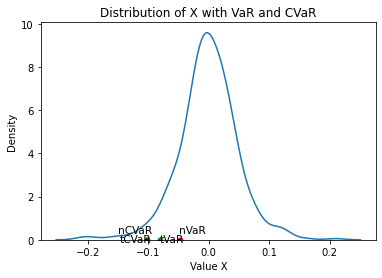

In [7]:
plt.plot()
sns.kdeplot(data)
plt.xlabel('Value X')
plt.ylabel('Density')
plt.title('Distribution of X with VaR and CVaR')

# Normal VaR point
plt.scatter([-normalVaR],[0], s=25, c='r')
plt.text((-normalVaR+0.02),0.2, 'nVaR', ha='center', va='bottom', fontsize=10.5)

# Normal CVaR point
plt.scatter([-normalCVaR],[0], s=25, c='r')
plt.text((-normalCVaR-0.02),0.2, 'nCVaR', ha='center', va='bottom', fontsize=10.5)

# tVaR point
plt.scatter([-tVaR],[0], s=25, c='g')
plt.text((-tVaR+0.02),-0.2, 'tVaR', ha='center', va='bottom', fontsize=10.5)

# Normal CVaR point
plt.scatter([-tCVaR],[0], s=25, c='g')
plt.text((-tCVaR-0.02),-0.2, 'tCVaR', ha='center', va='bottom', fontsize=10.5)

# Question 2

## 1. Covariance estimation techniques

### Exponential Weighted Method

In [8]:
import numpy as np
import pandas as pd

In [9]:
# Write the function to get the exponentially weighted covariance matrix
def EWM (df,timeType, lam):
    n = df.shape[0]
    m = df.shape[1]
    
    weights = np.empty(n)
    
    #if time is list from past to current
    if timeType == "increase":
        for i in range(n):
            weights[i] = (1-lam)*lam**(i-1)
        weights /= np.sum(weights) #normalize weight
    
    #if time is list from current to past
    elif timeType == "decrease":
        for i in range(n):
            weights[i] = (1-lam)*lam**(i-1)
        weights = np.flip(weights)
        weights /= np.sum(weights) #normalize weight
        
    else:
        raise TypeError ("Expected DataFrame.")
            
            
            
            
    #after we get the weights, we need to apply weights into covariance matirx        
    cov_matrix = np.empty(shape = [m, m])
    
    #calculate each columns mean
    col_mean = np.empty(m)
    for i in range(m):
        col_mean[i] = np.mean( df.iloc[:,i] )
    
    #stpe1
    for i in range(n):
        for j in range(m):
            df.iloc[i,j] = df.iloc[i,j] - col_mean[j]
     
    #step2
    for i in range(m):
        for j in range(m):
            temp = weights * df.iloc[:,i]
            cov_matrix[i,j] = np.dot(temp, df.iloc[:,j])
            
    return cov_matrix

## 2. Non PSD fixes for correlation matrices

### Rebonato and Jackel's Method (Near PSD)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [11]:
# Near PSD function
def near_psd(A):
    n = A.shape[0]
    eigval, eigvec = np.linalg.eigh(A)
    val = np.matrix(np.maximum(eigval, 0))
    vec = np.matrix(eigvec)
    
    T = 1/(np.multiply(vec,vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) ))) #already take the square root of T
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    out = B * B.T
    
    return out

### Higham PSD

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [13]:
# Higham PSD function
#*note: for higham PSD, we need to input the np.array type of data. DataFrame does not work

def _getAplus(A):
    eigval, eigvec = np.linalg.eigh(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return eigvec @ xdiag @ eigvec.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    iW = W05.I
    return  iW @ _getAplus(W05 @ A @ W05) @ iW

def _getPu(A, W=None):
    Aret = A.copy()
    for i in range(0, A.shape[0]):
        Aret[i,i] = 1
    return Aret

def _wgtNorm(A, W = None):
    W05 = np.sqrt(W)
    W05 = W05 @ A @ W05
    return (W05 * W05).sum()

def higham_nearestPSD(pc, W = None, epsilon = 1e-9, maxIter = 1000, tol = 1e-9):
    n = pc.shape[0]
    if W == None:
        W = np.identity(n)
        
    deltaS = np.zeros((n,n))
    
    Yk = pc.copy()
    norml = 9999999
    i = 1
    
    while i <= maxIter:
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W)
        norm = _wgtNorm(Yk - pc, W)
        
        w, v = np.linalg.eigh(Yk)
        minEigVal = np.min(w)
        
        if ((norm - norml) < tol) and (minEigVal > -epsilon):
            break
            
        norml = norm
        i = i + 1
        
    if i < maxIter:
        print("Converged in %d iterations.\n" % i)
    else:
        print("Converged failed after %d iterations.\n" % (i-1))
        
    return Yk 

## Simulation Method and Calculate VaR and CVaR

### Normal Monte Carlo

In [14]:
# Monte Carlo VaR
# VaR Function
def _mcVaR(returns, alpha):
    # first check wheather returns is series
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("You need to input a series.")

def mc_VaR (returns, mc_sim, time, alpha):
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    
    covMatrix = near_psd(np.array(covMatrix))
    #covMatrix = covMatrix
    
    weights = np.random.random(len(meanReturns))
    weights /= np.sum(weights) # normalize the weight
    

    meanMatrix = np.full(shape = (time, len(weights)), fill_value = meanReturns)
    meanMatrix = meanMatrix.T

    portfolio_sim = np.full(shape = (time, mc_sim), fill_value = 0)

    # MC loop

    # we can set a initial value of portofolio to see the absolute value
    # initial_money = 10000
    for m in range(mc_sim):
        '''
        Here we assume that daily return are distributed by a multvariate normal distribution
        Using Cholesky Decomposition, we get L, which is lower triangle.
        return = mean + L * Z, where Z is normal distribution (0,1)
        '''
        Z = np.random.normal(size = (time, len(weights)))
        L = np.linalg.cholesky(covMatrix)
        dailyReturns = meanMatrix + np.inner(L, Z)

        portfolio_sim[:,m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) # FV = PV * (1 + r)^t

    lastDay_return = portfolio_sim[-1,:]
    _mcVaR(lastDay_return, alpha = alpha)

In [15]:
# Monte Carlo CVaR
# CVaR Function
def _mcCVaR(returns, alpha):
    # first check wheather returns is series
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha = alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("You need to input a series.")
        
        
def mc_CVaR (returns, mc_sim, time, alpha):
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    
    covMatrix = near_psd(np.array(covMatrix))
    #covMatrix = covMatrix
    
    weights = np.random.random(len(meanReturns))
    weights /= np.sum(weights) # normalize the weight
    

    meanMatrix = np.full(shape = (time, len(weights)), fill_value = meanReturns)
    meanMatrix = meanMatrix.T

    portfolio_sim = np.full(shape = (time, mc_sim), fill_value = 0)

    # MC loop

    # we can set a initial value of portofolio to see the absolute value
    # initial_money = 10000
    for m in range(mc_sim):
        '''
        Here we assume that daily return are distributed by a multvariate normal distribution
        Using Cholesky Decomposition, we get L, which is lower triangle.
        return = mean + L * Z, where Z is normal distribution (0,1)
        '''
        Z = np.random.normal(size = (time, len(weights)))
        L = np.linalg.cholesky(covMatrix)
        dailyReturns = meanMatrix + np.inner(L, Z)

        portfolio_sim[:,m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) # FV = PV * (1 + r)^t

    lastDay_return = portfolio_sim[-1,:]
    _mcCVaR(lastDay_return, alpha = alpha)

### Normal Distribution or t-distribution

In [16]:
# Calculate VaR based different distribution
def parametricVaR (mean, std, distribution, alpha, dof):
    if distribution == "normal":
        VaR = (1-alpha/100) * std - mean #since normal distribution is symmetric, it is easy to calculate by using 1-alpha/100
    elif distribution == "t-distribution":
        VaR = np.sqrt((dof-2)/dof) * t.ppf(1-alpha/100, dof) * std - mean
    else:
        raise TypeError("Expected the distribution to be normal or t-distribution.")
    return VaR

In [17]:
# Calculate CVaR based different distribution
def parametricCVaR (mean, std, distribution, alpha, dof):
    if distribution == "normal":
        CVaR = (alpha/100)**-1 * norm.pdf( norm.ppf(alpha/100) ) * std - mean
    elif distribution == "t-distribution":
        x = t.ppf(alpha/100, dof)
        CVaR = -1/(alpha/100) * (1-dof)**-1 * (dof-2+x**2) * t.pdf(x,dof) *std - mean
    else:
        raise TypeError("Expected the distribution to be normal or t-distribution.")
    return CVaR

# Question 3

In [18]:
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")
prices = prices.drop(prices.columns[[0,1]], axis = 1)

In [19]:
portfolioA = portfolio.loc[portfolio['Portfolio'] == "A"][["Stock", "Holding"]]
portfolioB = portfolio.loc[portfolio['Portfolio'] == "B"][["Stock", "Holding"]]
portfolioC = portfolio.loc[portfolio['Portfolio'] == "C"][["Stock", "Holding"]]
portfolio = portfolio[["Stock", "Holding"]]

A = pd.Series(range(len(portfolioA)))
B = pd.Series(range(len(portfolioB)))
C = pd.Series(range(len(portfolioC)))
portfolioA = portfolioA.set_index(A)
portfolioB = portfolioB.set_index(B)
portfolioC = portfolioC.set_index(C)

pricesA = prices[list(portfolioA.Stock)]
pricesB = prices[list(portfolioB.Stock)]
pricesC = prices[list(portfolioC.Stock)]

Calculate the weights for each portfolios

In [20]:
# Function of calculate weight by using first day price
def cal_weight (data_hold, data_price):
    n = data_hold.shape[0]
    
    total = 0
    val = np.zeros((n,1))
    for i in range(n):
        name = data_hold.Stock[i]
        val[i] = data_price[name][0] * data_hold.Holding[i]
        total = total + val[i]
        
    weight = np.zeros((n,1))
    for j in range(n):
        weight[j] = val[j] / total
        
    return weight

In [21]:
weightsA = cal_weight(portfolioA, pricesA)
weightsB = cal_weight(portfolioB, pricesB)
weightsC = cal_weight(portfolioC, pricesC)
weights = cal_weight(portfolio, prices)

Applied the weights onto portfolio price to calculate the portfolio total value for each days

In [22]:
portfolioValueA = (weightsA.T @ pricesA.T).T
portfolioValueB = (weightsB.T @ pricesB.T).T
portfolioValueC = (weightsC.T @ pricesC.T).T
portfolioValue = (weights.T @ prices.T).T

Calculate the rate of returns for each portfolio

In [23]:
returnsA = np.array(portfolioValueA.pct_change().dropna())
returnsB = np.array(portfolioValueB.pct_change().dropna())
returnsC = np.array(portfolioValueC.pct_change().dropna())
returns = np.array(portfolioValue.pct_change().dropna())

In this question, we expected return on all stock is 0, thus I will remove mean for each day's portfolio returns. 

In [24]:
# Function of remove mean for a vector
def rm_mean (vector):
    mean = vector.mean()
    n = vector.shape[0]
    for i in range(n):
        vector[i] = vector[i] - mean
        
    return vector

In [25]:
returnsA = rm_mean(returnsA)
returnsB = rm_mean(returnsB)
returnsC = rm_mean(returnsC)
returns = rm_mean(returns)

Then, calculate the VaR and CVaR for each portfolio's return

In [26]:
# Calculate VaR based different distribution
def parametricVaR (mean, std, distribution, alpha, dof):
    if distribution == "normal":
        VaR = (1-alpha/100) * std - mean #since normal distribution is symmetric, it is easy to calculate by using 1-alpha/100
    elif distribution == "t-distribution":
        VaR = np.sqrt((dof-2)/dof) * t.ppf(1-alpha/100, dof) * std - mean
    else:
        raise TypeError("Expected the distribution to be normal or t-distribution.")
    return VaR

In [27]:
# Calculate CVaR based different distribution
def parametricCVaR (mean, std, distribution, alpha, dof):
    if distribution == "normal":
        CVaR = (alpha/100)**-1 * norm.pdf( norm.ppf(alpha/100) ) * std - mean
    elif distribution == "t-distribution":
        x = t.ppf(alpha/100, dof)
        CVaR = -1/(alpha/100) * (1-dof)**-1 * (dof-2+x**2) * t.pdf(x,dof) *std - mean
    else:
        raise TypeError("Expected the distribution to be normal or t-distribution.")
    return CVaR

In [28]:
def getVaRnCVaR(returns):
    mean = returns.mean()
    std = returns.std()
    distribution = "t-distribution"
    alpha = 5
    dof = len(returns) - 1
    
    VaR = parametricVaR (mean, std, distribution, alpha, dof)
    CVaR = parametricCVaR (mean, std, distribution, alpha, dof)
    
    return VaR, CVaR

In [29]:
A_VaR, A_CVaR = getVaRnCVaR(returnsA)
B_VaR, B_CVaR = getVaRnCVaR(returnsB)
C_VaR, C_CVaR = getVaRnCVaR(returnsC)
VaR, CVaR = getVaRnCVaR(returns)

Show the table

In [30]:
port_names = ["Portfolio A", "Portfolio B", "Portfolio C", "Total Portfolio"]
port_VaR = [A_VaR, B_VaR, C_VaR, VaR]
port_CVaR = [A_CVaR, B_CVaR, C_CVaR, CVaR]
ans = pd.DataFrame(list(zip(port_names, port_VaR, port_CVaR)), columns = ['Name','VaR', 'CVaR'])
ans

,Name,VaR,CVaR
0,Portfolio A,0.020991,0.026141
1,Portfolio B,0.018944,0.023591
2,Portfolio C,0.016883,0.021025
3,Total Portfolio,0.017087,0.021279
